In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50, MobileNet, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from sklearn.metrics import precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

In [3]:
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

x_train_full, x_test = x_train_full / 255.0, x_test / 255.0

#creating te validation set
x_train, x_val = x_train_full[:40000], x_train_full[40000:]
y_train, y_val = y_train_full[:40000], y_train_full[40000:]


y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


BUILD RESNET-50

In [4]:
def build_resnet50():
    resnet50_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    x = tf.keras.layers.GlobalAveragePooling2D()(resnet50_base.output)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)
    resnet50_model = tf.keras.models.Model(inputs=resnet50_base.input, outputs=x)

    for layer in resnet50_model.layers[:-4]:
        layer.trainable = False

    resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    history_resnet50 = resnet50_model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr]
    )
    return history_resnet50

BUILD MOBILENET

In [5]:
def build_mobilenet():
    mobilenet_base = MobileNet(weights=None, include_top=False, input_shape=(32, 32, 3))
    x = layers.GlobalAveragePooling2D()(mobilenet_base.output)
    x = layers.Dense(10, activation='softmax')(x)

    mobilenet_model = models.Model(inputs=mobilenet_base.input, outputs=x)

    mobilenet_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

    # model training
    history_mobilenet = mobilenet_model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr]
    )

    return history_mobilenet

BUILD VGG16

In [6]:
def build_vgg16():
    vgg16_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    x = tf.keras.layers.Flatten()(vgg16_base.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)
    vgg16_model = tf.keras.models.Model(inputs=vgg16_base.input, outputs=x)

    for layer in vgg16_model.layers[:-4]:
        layer.trainable = False

    vgg16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    history_vgg16 = vgg16_model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr]
    )
    return history_vgg16

Train The Models

In [7]:
print("\nBuilding ResNet50 model...")
history_resnet50 = build_resnet50()

print("\nBuilding MobileNet model...")
history_mobilenet = build_mobilenet()

print("\nBuilding VGG16 model...")
history_vgg16 = build_vgg16()


Building ResNet50 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - accuracy: 0.1324 - loss: 2.4426 - val_accuracy: 0.1962 - val_loss: 2.1889 - learning_rate: 1.0000e-04
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.2337 - loss: 2.1613 - val_accuracy: 0.2539 - val_loss: 2.1075 - learning_rate: 1.0000e-04
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.2672 - loss: 2.0929 - val_accuracy: 0.2636 - val_loss: 2.0558 - learning_rate: 1.0000e-04
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.2817 - loss: 2.0445 - val_accuracy: 0.2679 - val_loss: 2.0240 - learning_rate: 1.0000e-04
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.2975 - loss: 2.0061 - val_accuracy: 0.3066 - val_loss: 1.9881 - learning_rate: 1.0000e-04
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.3023 - loss: 1.9874 - val_accuracy: 0.3103 - val_loss: 1

Evaluate Models On The Test Set

In [8]:
print("\nEvaluating ResNet50 model on test set...")
test_loss_resnet50, test_accuracy_resnet50 = history_resnet50.model.evaluate(x_test, y_test)
print(f"ResNet50 Test Accuracy: {test_accuracy_resnet50:.4f}")

print("\nEvaluating MobileNet model on test set...")
test_loss_mobilenet, test_accuracy_mobilenet = history_mobilenet.model.evaluate(x_test, y_test)
print(f"MobileNet Test Accuracy: {test_accuracy_mobilenet:.4f}")

print("\nEvaluating VGG16 model on test set...")
test_loss_vgg16, test_accuracy_vgg16 = history_vgg16.model.evaluate(x_test, y_test)
print(f"VGG16 Test Accuracy: {test_accuracy_vgg16:.4f}")



Evaluating ResNet50 model on test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3384 - loss: 1.8978
ResNet50 Test Accuracy: 0.3318

Evaluating MobileNet model on test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4835 - loss: 1.4643
MobileNet Test Accuracy: 0.4765

Evaluating VGG16 model on test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5727 - loss: 1.2160
VGG16 Test Accuracy: 0.5747


Accuracy And Loss Plots

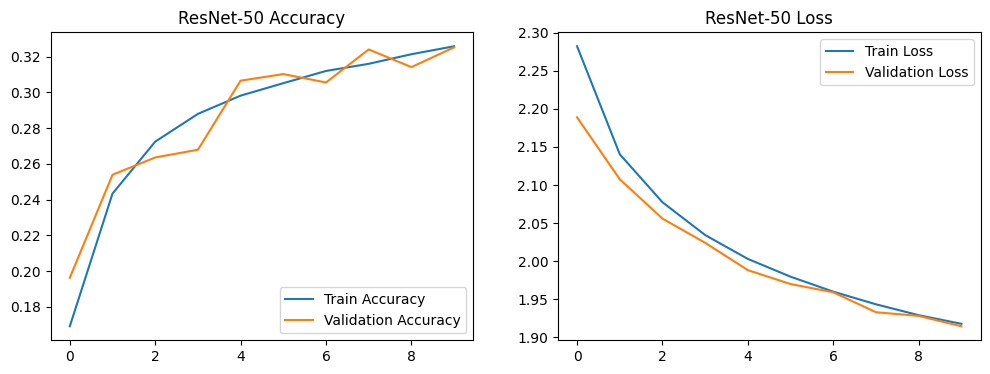

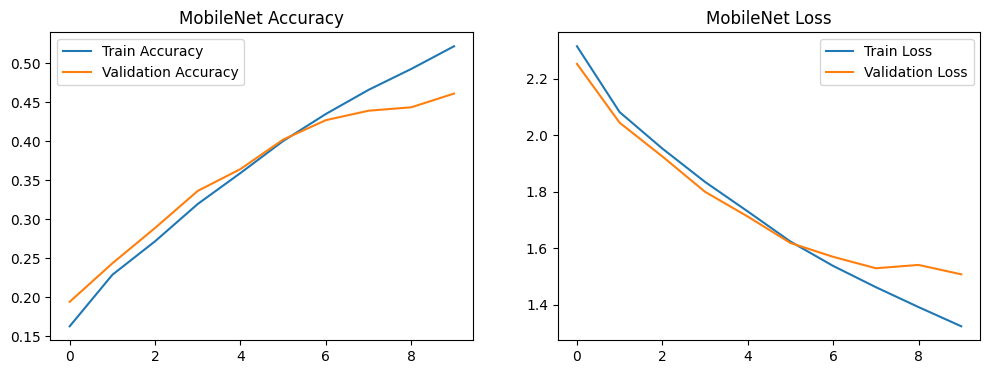

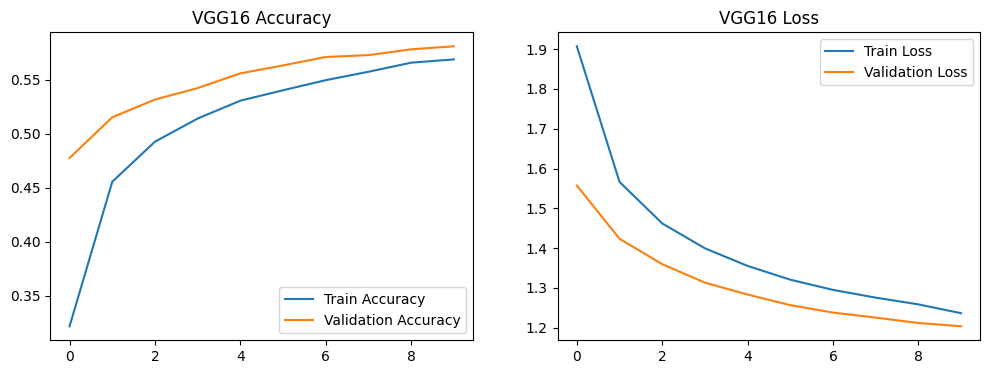

In [11]:
def training_curves(history, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.show()

training_curves(history_resnet50, "ResNet-50")
training_curves(history_mobilenet, "MobileNet")
training_curves(history_vgg16, "VGG16")

Table Of Accuracy and Loss Values Accross Model Training

In [10]:
import pandas as pd

def get_accuracy(history, model_name):
    df = pd.DataFrame({
        f'{model_name} Training Acc': history.history['accuracy'],
        f'{model_name} Validation Acc': history.history['val_accuracy'],
    })
    df['epoch'] = df.index + 1
    return df[df['epoch'] % 2 == 0]

df_resnet = get_accuracy(history_resnet50, "ResNet")
df_vgg = get_accuracy(history_vgg16, "VGG")
df_mobilenet = get_accuracy(history_mobilenet, "MobileNet")


combined_df = pd.merge(df_resnet, df_vgg, on='epoch', how='outer')
combined_df = pd.merge(combined_df, df_mobilenet, on='epoch', how='outer')

combined_df = combined_df[[
    "epoch",
    "ResNet Training Acc", "ResNet Validation Acc",
    "VGG Training Acc", "VGG Validation Acc",
    "MobileNet Training Acc", "MobileNet Validation Acc"
]]

combined_df.set_index('epoch', inplace=True)
combined_df

,ResNet Training Acc,ResNet Validation Acc,VGG Training Acc,VGG Validation Acc,MobileNet Training Acc,MobileNet Validation Acc
epoch,,,,,,
2,0.243350,0.2539,0.455675,0.5153,0.228700,0.2434
4,0.288000,0.2679,0.514200,0.5424,0.319600,0.3364
6,0.305200,0.3103,0.540375,0.5634,0.400425,0.4023
8,0.316050,0.3241,0.557500,0.5729,0.466100,0.4393
10,0.325875,0.3253,0.568950,0.5811,0.522025,0.4613
